In [542]:
import ee 
import shapely as shp
import pandas as pd
import numpy as np
import geopandas as gpd
import ast
from shapely.geometry import Polygon, MultiPolygon, Point

In [543]:
import ee

# Trigger the authentication flow.
#ee.Authenticate()

# Initialize the library.
ee.Initialize()


In [544]:
basins = ee.FeatureCollection("WWF/HydroSHEDS/v1/Basins/hybas_9");
basinsall = basins
image = ee.Image('WWF/HydroSHEDS/03VFDEM');

a = pd.read_csv('a.csv')

In [271]:
def numberOfPixels(img):
    imgDescription = ee.Algorithms.Describe( img )
    height = ee.List( ee.Dictionary( ee.List(  ee.Dictionary( imgDescription ).get("bands") ).get(0) ).get("dimensions") ).get(0);
    width = ee.List( ee.Dictionary( ee.List(  ee.Dictionary( imgDescription ).get("bands") ).get(0) ).get("dimensions") ).get(1);
  
    print("width", width.getInfo() )
    print("height", height.getInfo() )
  
    return  ee.Number( width ).multiply( ee.Number( height ) ).getInfo()


In [272]:
geom = pd.read_csv('a.csv')
geom = geom.sort_values('Latitude (decimal degrees)')
latlon = [[i,j] for [i,j] in zip(geom['Longitude (decimal degrees)'].values,
                              geom['Latitude (decimal degrees)'].values)][:-1]
c=0
for i in latlon[1:400]:
    if (np.isnan(i[0]))|(np.isnan(i[1])):
        latlon.pop(c)
    c+=1

In [273]:
pts = ee.Geometry.MultiPoint(latlon)

In [274]:
basins = basins.filterBounds(pts)

In [275]:
#basins = ee.FeatureCollection(basins)
#basins = basins.merge(basins2)
import matplotlib.pyplot as plt

In [276]:
a1  = basins.getInfo()

In [277]:
b=a1

<ipython-input-278-198b47bfee93>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ax.plot(np.array(b['features'][i]['geometry']['coordinates']).squeeze()[:,0],np.array(b['features'][i]['geometry']['coordinates']).squeeze()[:,1])
<ipython-input-278-198b47bfee93>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ax.plot(np.array(b['features'][i]['geometry']['coordinates']).squeeze()[:,0],np.array(b['features'][i]['geometry']['coordinates']).squeeze()[:,1])
<ipython-input-278-198b47bfee93>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nes

here
here
here
here
here
here
here
here
here
here
here
here
here


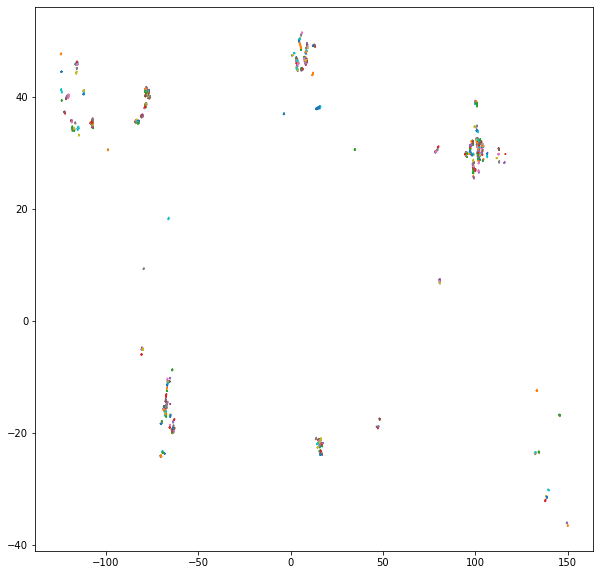

In [278]:
fig,ax = plt.subplots(figsize=(10,10))
for i in range(len(b['features'])):
    try:
        ax.plot(np.array(b['features'][i]['geometry']['coordinates']).squeeze()[:,0],np.array(b['features'][i]['geometry']['coordinates']).squeeze()[:,1])
    except:
        print('here')

In [84]:
def queryeach(b):
    feat = ee.Feature(b)
    print(feat.getInfo())

In [85]:
myImage = image.clip(ee.FeatureCollection(basins.first().geometry()))

In [86]:
#numberOfPixels(myImage)

width 139200
height 390000


54288000000

In [104]:
drainageDirectionVis = {
  'min': 0.0,
  'max': 2000,
  }

In [279]:
#def meanDictionary(geom):
    #def featurescount(feature):
        #return feature
a = image.reduceRegions(basins,ee.Reducer.mean());
    #return a.filter(ee.Filter.notNull(['mean'])).map(featurescount)
#b = basins.map(meanDictionary)

In [174]:
mytask.active()

False

In [280]:
mytask = ee.batch.Export.table.toDrive(collection=a, folder='data_earth_engine', description='basins_pts', fileFormat='CSV')

mytask.start()

In [287]:
mytask.active()

False

In [168]:
from ee import Export

ImportError: cannot import name 'Export' from 'ee' (/Users/gr_1/opt/miniconda3/envs/ee/lib/python3.9/site-packages/ee/__init__.py)

In [ ]:
def meanDictionary(geom):
    return image.clip(geom.geometry())
mns = basins.map(meanDictionary)

AttributeError: 'Element' object has no attribute 'reduceRegion'

In [ ]:
basins.getInfo()

In [283]:
import matplotlib.pyplot as plt

In [284]:
a = np.array(a)

## Begin basin analysis

In [550]:
basins_2 = pd.read_pickle('BASINS_ALL')

In [551]:
if 0: # we did it once so we can load it now
    up_basins = []
    ids = basins_2['HYBAS_ID'].values
    down_ids = basins_2['NEXT_DOWN'].values
    c=0
    def recurbas(l,c):
        c+=1
        idx = ids[down_ids==l]
        for j in idx:
            if j != l:
                if c>10000:
                    print(j,l)
                idx = np.append(idx,recurbas(j,c))

        return idx
    for i in range(len(ids)):
        up_basins.append(recurbas(ids[i],c))
        c=0
        if np.mod(i,1000) == 0:
            print(i/len(ids))

0.0
0.001967767960802062
0.003935535921604124
0.005903303882406187


KeyboardInterrupt: 

In [552]:
pt_basins = pd.read_csv('basins_pts.csv')

In [553]:
a = pd.read_csv('a.csv')
basins_gpd = gpd.GeoDataFrame(pt_basins,geometry = ptgeo)

In [554]:
pts = []
for x,y in zip(a["Longitude (decimal degrees)"],a['Latitude (decimal degrees)']):
    pts.append(Point(x,y))

In [555]:
pt_gpd = gpd.GeoDataFrame(a)
a['geometry'] = pts

In [ ]:
ptgeo = []
for i, geo in enumerate(pt_basins['.geo']):
    geo2 = ast.literal_eval(geo)
    print(i)
    try:
        ptgeo.append(Polygon(geo2['coordinates'][0]))
    except:
        ptgeo.append(MultiPolygon(geo2['coordinates'][0],geo2['coordinates'][1]))


In [557]:
basin['HYBAS_ID'].values

array([7090548200])

In [560]:
basins_2 = basins_2.set_index('HYBAS_ID')

In [577]:
c=1
for i,pt in pt_gpd.iterrows():
    basin = basins_gpd[basins_gpd.contains(pt.geometry)]
    if len(basin) >0:
        pt_gpd.loc[i,'Basin_id'] = basin['HYBAS_ID'].values
        upstream_basins = basins_2["NEXT_UP"][basin['HYBAS_ID']].values[0]
        if len(upstream_basins) > 0:
            basum = basins_2['mean'][upstream_basins].values
            areas = basins_2['SUB_AREA'][upstream_basins].values
            pt_gpd.loc[i,'mean_topo'] = (basin['mean'].values*basin['SUB_AREA'].values +
                                         np.sum(np.multiply(basum[basum>0],areas[basum>0])))/(np.sum(areas[basum>0])+
                                                                                              basin['SUB_AREA'].values)[0]
    else:
        c+=1

In [574]:
(basin['mean'].values*basin['SUB_AREA'].values +
                                         np.sum(np.multiply(basum[basum>0],areas[basum>0])))/(np.sum(areas[basum>0])+
                                                                                              basin['SUB_AREA'].values)

array([], dtype=float64)

In [578]:
pt_gpd['mean_topo'][pt_gpd['mean_topo']>0]

38      1338.741081
39      1338.741081
40      1061.507329
41      1309.354593
42      1338.741081
           ...     
1374     376.081101
1375     376.081101
1376     376.081101
1377     376.081101
1378     376.081101
Name: mean_topo, Length: 539, dtype: float64

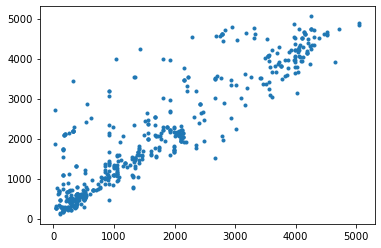

In [580]:
plt.plot(pt_gpd['mean_topo'],pt_gpd['Mean Basin Elevation (m)'],'.')

In [464]:
basins_2

,system:index,COAST,DIST_MAIN,DIST_SINK,ENDO,HYBAS_ID,MAIN_BAS,NEXT_DOWN,NEXT_SINK,ORDER,PFAF_ID,SORT,SUB_AREA,UP_AREA,mean,.geo,NEXT_UP
0,00000000000000000001,0,10.1,10.1,0,2090644710,2090017320,2090017320,2090017320,1,216050430,12628,155.0,2535.7,364.664868,"{""type"":""Polygon"",""coordinates"":[[[-0.35416858...","[2090643100, 2090642990, 2090642360, 209064209..."
1,00000000000000000002,0,10.1,10.1,0,2090644510,2090017320,2090017320,2090017320,2,216050421,12629,123.2,1523.2,214.686357,"{""type"":""Polygon"",""coordinates"":[[[-0.25478414...","[2090642210, 2090642200, 2090640400, 209064070..."
2,00000000000000000003,0,27.0,27.0,0,2090642210,2090017320,2090644510,2090017320,2,216050423,12630,101.3,1248.6,355.033959,"{""type"":""Polygon"",""coordinates"":[[[-0.20833363...","[2090640400, 2090640700, 2090638820, 209063877..."
3,00000000000000000004,0,27.0,27.0,0,2090642200,2090017320,2090644510,2090017320,3,216050422,12631,151.5,151.6,745.204998,"{""type"":""Polygon"",""coordinates"":[[[-0.36306891...",[]
4,00000000000000000005,0,39.7,39.7,0,2090640400,2090017320,2090642210,2090017320,2,216050425,12632,46.5,954.9,365.145831,"{""type"":""Polygon"",""coordinates"":[[[-0.12083271...","[2090638820, 2090638770, 2090636040, 2090636050]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508185,001000000000000035ee,1,0.0,0.0,0,6090040190,6090040190,0,6090040190,0,673000050,60616,627.8,627.8,178.638380,"{""type"":""MultiPolygon"",""coordinates"":[[[[-90.8...",[]
508186,001000000000000035ef,1,0.0,0.0,0,6090040280,6090040280,0,6090040280,0,673000073,60620,440.8,440.8,73.030976,"{""type"":""MultiPolygon"",""coordinates"":[[[[-90.8...",[]
508187,001000000000000035f0,1,0.0,0.0,0,6090040320,6090040320,0,6090040320,0,673000075,60622,872.6,872.6,310.911204,"{""type"":""Polygon"",""coordinates"":[[[-91.5160394...",[]
508188,001000000000000035f1,1,0.0,0.0,0,6090040380,6090040380,0,6090040380,0,673000077,60624,432.3,432.3,208.277812,"{""type"":""Polygon"",""coordinates"":[[[-91.3833321...",[]


In [446]:
basins_2.index[-1]

508189